<a href="https://colab.research.google.com/github/Nolanole/DS-Unit-2-Applied-Modeling/blob/master/SOLUTION_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install matplotlib==3.1.0

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

Look at the data

In [0]:
train.head().T

,0,1,2,3,4
Inspection ID,2088270,555268,1751394,1763905,453326
DBA Name,"TOM YUM RICE & NOODLE, INC.",FILLING STATION & CONVENIENCE STORE,A P DELI,FRANK'S CHICAGO SHRIMP HOUSE,MORRILL
AKA Name,TOM YUM CAFE,FILLING STATION & CONVENIENCE STORE,A P DELI,FRANK'S CHICAGO SHRIMP HOUSE,MORRILL
License #,2.35491e+06,1.0449e+06,47405,6414,24571
Facility Type,Restaurant,Grocery Store,Restaurant,Restaurant,School
Risk,Risk 1 (High),Risk 3 (Low),Risk 1 (High),Risk 2 (Medium),Risk 1 (High)
Address,608 W BARRY,6646-6658 S WESTERN AVE,2025 E 75TH ST,4459 S ARCHER AVE,6011 S Rockwell (2600W) AVE
City,CHICAGO,CHICAGO,CHICAGO,CHICAGO,CHICAGO
State,IL,IL,IL,IL,IL
Zip,60657,60636,60649,60632,60629


Make X and y dataframes for train and test. The target is the `Fail` column.

In [0]:
X_train = train.drop(columns='Fail')
y_train = train['Fail']

X_test = test.drop(columns='Fail')
y_test = test['Fail']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51916, 16), (17306, 16), (51916,), (17306,))

This is a class imbalanced binary classification problem.

In [0]:
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

See descriptive stats for the numeric features.

In [0]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Inspection ID,51916.0,1.330265e+06,620266.383172,44250.000000,6.796205e+05,1.424226e+06,1.946952e+06,2.279709e+06
License #,51911.0,1.549491e+06,901828.261447,0.000000,1.140745e+06,1.958619e+06,2.215507e+06,8.700606e+06
Zip,51890.0,6.062883e+04,22.736963,60007.000000,6.061400e+04,6.062500e+04,6.064300e+04,6.082700e+04
Latitude,51718.0,4.187957e+01,0.081126,41.644670,4.183030e+01,4.189017e+01,4.193917e+01,4.202106e+01
Longitude,51718.0,-8.767666e+01,0.059509,-87.914428,-8.770786e+01,-8.766652e+01,-8.763446e+01,-8.752509e+01


Should `Zip` be categorical? How many unique values does it have?

In [0]:
X_train['Zip'].nunique()

86

Ok, `Zip` can be made categorical.

In [0]:
X_train['Zip'] = X_train['Zip'].astype('str')

See descriptive stats for the non-numeric features.

In [0]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
State,51906,1,IL,51906
Risk,51904,3,Risk 1 (High),37731
City,51863,39,CHICAGO,51659
Inspection Type,51915,51,Canvass,24170
Zip,51916,87,60647.0,1782
Facility Type,51692,329,Restaurant,34264
Inspection Date,51916,2257,2017-03-23T00:00:00,50
Location,51718,13410,"{'longitude': '-87.91442843927047', 'latitude'...",741
Address,51916,13954,11601 W TOUHY AVE,741
AKA Name,51293,16350,SUBWAY,802


`Risk` seems like it could be a highly predictive feature. 

In [0]:
X_train['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

Also, `Risk` doesn't have many nulls. (And `category_encoders` will automatically impute the mode for string columns with nulls.)

In [0]:
X_train.isnull().sum().sort_values()

Inspection ID         0
DBA Name              0
Address               0
Zip                   0
Inspection Date       0
Inspection Type       1
License #             5
State                10
Risk                 12
City                 53
Latitude            198
Longitude           198
Location            198
Facility Type       224
AKA Name            623
Violations         9655
dtype: int64

So, fit a fast, first baseline with just the `Risk` feature.

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

features = ['Risk']

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        n_jobs=-1, 
        random_state=42
    )
)

cross_val_score(pipe, X_train[features], y_train, cv=5, scoring='roc_auc')

array([0.52447041, 0.51747207, 0.52708912, 0.52415019, 0.50714268])

So, `Risk` by itself may not be a highly predictive feature after all.

Look at `Violations`. It sounds interesting, and had the highest cardinality by far among the non-numeric columns.

In [0]:
X_train['Violations'].value_counts()

45. FOOD HANDLER REQUIREMENTS MET - Comments: FOUND FOODHANDLERS AT PREMISES WITH NO FOODHANDLER CERTIFICATES. MUST PROVIDE.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

This looks like text about inspections results. Are these from _previous_ inspections, or from the _present_ inspection? 

It's not clear from the data description PDF:

>Violations: An establishment can receive one or more of 45 distinct violations (violation
numbers 1-44 and 70). For each violation number listed for a given establishment, the
requirement the establishment must meet in order for it to NOT receive a violation is
noted, followed by a specific description of the findings that caused the violation to be
issued. 

But it's possible, even probable, that `Violations` is from the present inspection, documenting the results of the inspection. If so, this information wouldn't be known and available until _after_ completing the inspection, right?

Let's try using it and see what happens. We can't use raw text as-is in our model, but we can extract the violation number from the beginning of the violation text:

In [0]:
X_train['Violation Number'] = X_train['Violations'].str.split('.').str[0]
X_train['Violation Number'].value_counts()

32    9375
33    6461
34    3914
18    3772
30    3542
35    2125
31    1508
2     1484
38    1466
3     1118
16     769
11     722
29     722
36     487
19     436
41     377
24     343
8      334
12     330
9      318
14     268
10     265
21     240
6      197
37     196
1      192
26     177
40     167
45     144
13     123
22     107
4       62
42      62
55      61
47      57
51      49
43      43
5       38
49      34
7       31
27      21
58      17
28      15
39      14
53      10
17      10
44       9
25       9
48       7
57       7
23       7
56       7
50       4
52       3
20       2
54       2
15       1
Name: Violation Number, dtype: int64

Add `Violation Number` to our list of features used, and get new cross-validation scores for our pipeline.

In [0]:
features += ['Violation Number']
cross_val_score(pipe, X_train[features], y_train, cv=5, scoring='roc_auc')

array([0.97788585, 0.97784779, 0.9731593 , 0.97395115, 0.97589337])

The nearly-perfect ROC AUC scores are too good to be true. `Violation` is leakage and shouldn't be used in a real-world model to predict the results of future inspections.

It's like the Xavier Amatriain quote:

>Make sure your training features do not contain data from the “future” (aka time traveling). While this might be easy and obvious in some cases, it can get tricky. ... If your test metric becomes really good all of the sudden, ask yourself what you might be doing wrong. Chances are you are time travelling or overfitting in some way.

Let's try again, with some different features.

In [0]:
features = ['State', 'Risk', 'City', 'Inspection Type', 'Zip', 'Facility Type']
X_train[features].describe()

,State,Risk,City,Inspection Type,Zip,Facility Type
count,51906,51904,51863,51915,51916,51692
unique,1,3,39,51,87,329
top,IL,Risk 1 (High),CHICAGO,Canvass,60647.0,Restaurant
freq,51906,37731,51659,24170,1782,34264


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 200),
    'randomforestclassifier__class_weight': ['balanced', None], 
    'randomforestclassifier__min_samples_leaf': [1, 10, 100, 1000]
}

search = RandomizedSearchCV(
    estimator=pipe, 
    param_distributions=param_distributions, 
    n_iter=20, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train[features], y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.9s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                               

In [0]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.6989263774780902


The cross-validated ROC AUC score is now > 0.60.

The test score is similar, still > 0.60.

In [0]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_
best.fit(X_train[features], y_train)
y_pred_proba = best.predict_proba(X_test[features])[:,1]
roc_auc_score(y_test, y_pred_proba)

0.6749816196719799

This model is alreading passing the SC, just using 6 of 16 features (excluding Violations), just ordinal encoding (with arbitrary order), just a little hyperparameter optimization, no feature engineering, and no gradient boosting.

So there are many things you could try to increase the score.

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Confusion Matrix
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

#### Confusion Matrix

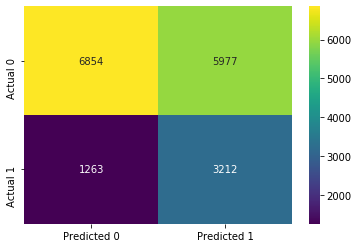

In [0]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

y_pred = best.predict(X_test[features])
plot_confusion_matrix(y_test, y_pred);

#### Permutation Importance

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

preprocessor = ce.OrdinalEncoder()
X_train_transformed = preprocessor.fit_transform(X_train[features])

model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=5, cv='prefit')
permuter.fit(X_train_transformed, y_train)
eli5.show_weights(permuter, top=None, feature_names=features)

Weight,Feature
0.2207 ± 0.0044,Inspection Type
0.1417 ± 0.0025,Zip
0.1080 ± 0.0031,Facility Type
0.0745 ± 0.0034,Risk
0.0030 ± 0.0005,City
0.0000 ± 0.0000,State


According to Permutation Importances, Inspection Type is more important than Zip.

According to Feature Importances, location features are the most important (Zip) and least important (City, State). 

It makes sense that State is useless (there's only one unique value, Illinois) and City is basically useless (there are only 3 unique values, in/near Chicago).

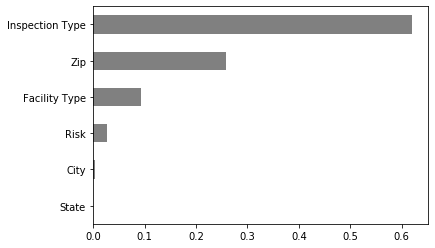

In [0]:
rf = best.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, features)
importances.sort_values().plot.barh(color='grey');

#### Shapley Values

In [0]:
data_for_prediction = X_train_transformed.loc[0]

In [0]:
data_for_prediction

State              1
Risk               1
City               1
Inspection Type    1
Zip                1
Facility Type      1
Name: 0, dtype: int64

In [0]:
X_train[features].loc[0]

State                         IL
Risk               Risk 1 (High)
City                     CHICAGO
Inspection Type          Canvass
Zip                      60657.0
Facility Type         Restaurant
Name: 0, dtype: object

In [0]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

#### Partial Dependence Plot, 1 feature isolation

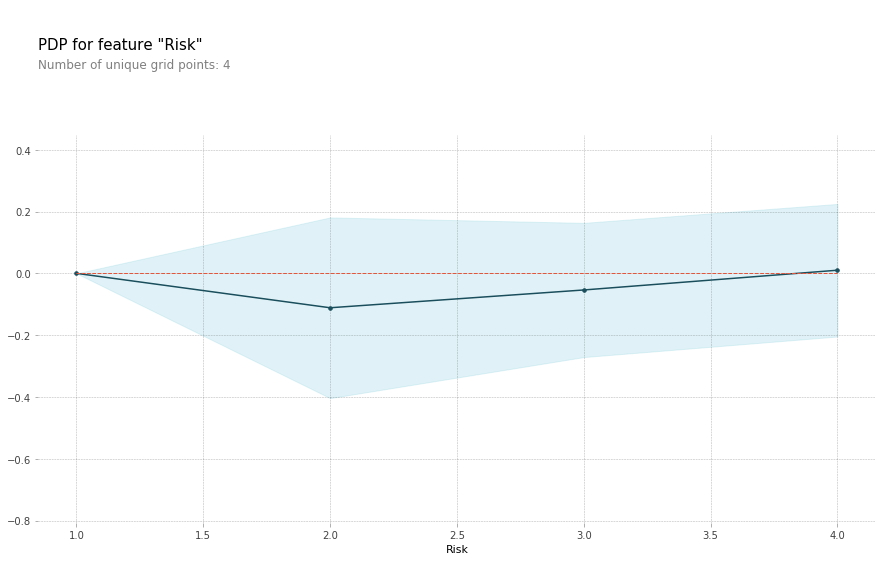

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Risk'
pdp_isolated = pdp_isolate(model=model, dataset=X_train_transformed, 
                           model_features=X_train_transformed.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

In [0]:
X_train_transformed['Risk'].value_counts()

1    37731
3    10136
2     4037
4       12
Name: Risk, dtype: int64

In [0]:
X_train['Risk'].value_counts(dropna=False)

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
NaN                   12
Name: Risk, dtype: int64

#### Partial Dependence Plot, 2 features interaction

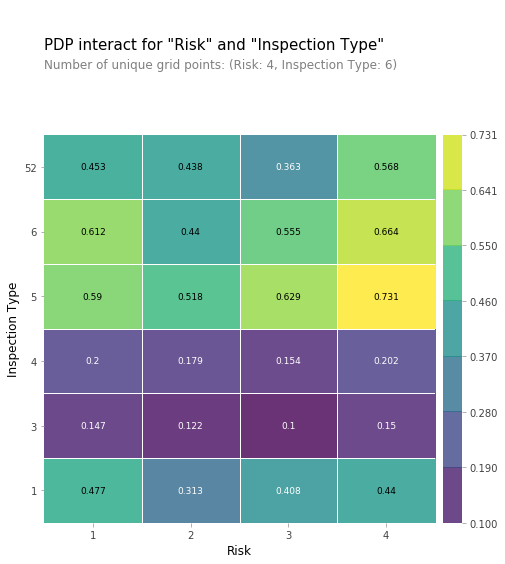

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Risk', 'Inspection Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_transformed, 
    model_features=X_train_transformed.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);